In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import gc
from IPython.core.display import display, HTML, display_pretty
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
from imblearn.datasets import make_imbalance
os.chdir('/home/sambeet/data/dsg/')
import fastFM as fm
import time
from sklearn.preprocessing import OneHotEncoder
from fastFM import als
from sklearn.metrics import roc_auc_score

In [2]:
trade = pd.read_csv('Trade.csv',parse_dates=['TradeDateKey'])
#trade['CustomerInterest'] = True
#trade = trade[trade.TradeDateKey >= '11-01-2017']
trade['BuySell'] = trade['BuySell'].astype('category')
trade['TradeStatus'] = trade['TradeStatus'].astype('category')
trade['CustomerInterest'] = trade['CustomerInterest'].astype('bool')
trade['year'] = trade.TradeDateKey.dt.year
trade['month'] = trade.TradeDateKey.dt.month
trade['weekofyear'] = trade.TradeDateKey.dt.weekofyear
trade['IsinIdx'] = trade['IsinIdx'].astype(str) + '_' + trade['BuySell'].astype(str)
encoder_bondbs = LabelEncoder()
encoder_bondbs.fit(trade['IsinIdx'])
trade['IsinIdx'] = encoder_bondbs.transform(trade['IsinIdx'])
test = trade[['CustomerIdx','IsinIdx']].drop_duplicates()
trade.drop(['BuySell','TradeDateKey','NotionalEUR','Price','TradeStatus','month'],axis=1,inplace=True)
trade.head()

,CustomerIdx,IsinIdx,CustomerInterest,year,weekofyear
0,2789,50547,True,2016,49
1,2574,9951,True,2017,13
2,2574,42358,True,2017,16
3,2574,53597,True,2017,10
4,2574,51440,True,2016,46


In [3]:
test.shape

(2046077, 2)

In [4]:
yearlist = list(np.unique(trade.year))
weekofyearlist = list(np.unique(trade.weekofyear))
start = time.time()
for year in yearlist:
    print year
    for weekofyear in weekofyearlist:
        if year == 2017 and weekofyear == 53:
            continue
        elif year == 2018 and weekofyear >= 17:
            continue
        else:
            print weekofyear
            temp = test.copy()
            temp = temp.sample(frac=0.1)
            temp['year'] = year
            temp['weekofyear'] = weekofyear
            temp['CustomerInterest'] = False
            trade = pd.concat([trade,temp],axis=0)
end = time.time()
print end - start,'seconds'

2016
1


/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
2017
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
2018
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
124.72400713 seconds


In [5]:
trade.shape

(31519589, 5)

In [6]:
categorical_holdings = ['CustomerIdx','IsinIdx','year','weekofyear']
predictors_holdings = ['CustomerIdx','IsinIdx','year','weekofyear']
target_holdings = 'CustomerInterest'

In [7]:
trade = trade[~((trade.year == 2018) & (trade.weekofyear >= 16))].reset_index(drop=True)
del temp,test
gc.collect()
trade.shape

(31288906, 5)

In [8]:
trade = trade.groupby(['CustomerIdx','IsinIdx','year','weekofyear'])['CustomerInterest'].sum().reset_index()
trade['CustomerInterest'] = trade.CustomerInterest >= 1
trade.head()

,CustomerIdx,IsinIdx,year,weekofyear,CustomerInterest
0,0,14131,2016,13,False
1,0,14131,2016,19,False
2,0,14131,2016,30,False
3,0,14131,2016,32,False
4,0,14131,2016,37,False


In [9]:
trade.CustomerInterest.mean()

0.05818555594711834

In [10]:
n_iter = 100
step_size = 1
start = time.time()
for col in list(categorical_holdings):
    trade[col] = trade[col].astype('category')
encoder = OneHotEncoder().fit(trade[predictors_holdings])
X_train, X_test, y_train, y_test = train_test_split(trade[predictors_holdings], trade[target_holdings])
y_train = y_train.astype(int).values
y_test = y_test.astype(int).values
y_train[y_train == 0] = -1
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)
auc_train = []
auc_test = []
z = als.FMClassification(n_iter=0, l2_reg_w=0.1, l2_reg_V=0.1, rank=4)
z.fit(X_train, y_train)
for i in range(n_iter):
    print 'Training Iteration #',i+1
    z.fit(X_train, y_train, n_more_iter=step_size)
    auc_train.append(roc_auc_score(y_train,z.predict_proba(X_train)))
    auc_test.append(roc_auc_score(y_test,z.predict_proba(X_test)))
end = time.time()
print (end - start)/60, ' minutes'

Training Iteration # 1
Training Iteration # 2
Training Iteration # 3
Training Iteration # 4
Training Iteration # 5
Training Iteration # 6
Training Iteration # 7
Training Iteration # 8
Training Iteration # 9
Training Iteration # 10
Training Iteration # 11
Training Iteration # 12
Training Iteration # 13
Training Iteration # 14
Training Iteration # 15
Training Iteration # 16
Training Iteration # 17
Training Iteration # 18
Training Iteration # 19
Training Iteration # 20
Training Iteration # 21
Training Iteration # 22
Training Iteration # 23
Training Iteration # 24
Training Iteration # 25
Training Iteration # 26
Training Iteration # 27
Training Iteration # 28
Training Iteration # 29
Training Iteration # 30
Training Iteration # 31
Training Iteration # 32
Training Iteration # 33
Training Iteration # 34
Training Iteration # 35
Training Iteration # 36
Training Iteration # 37
Training Iteration # 38
Training Iteration # 39
Training Iteration # 40
Training Iteration # 41
Training Iteration # 42
T

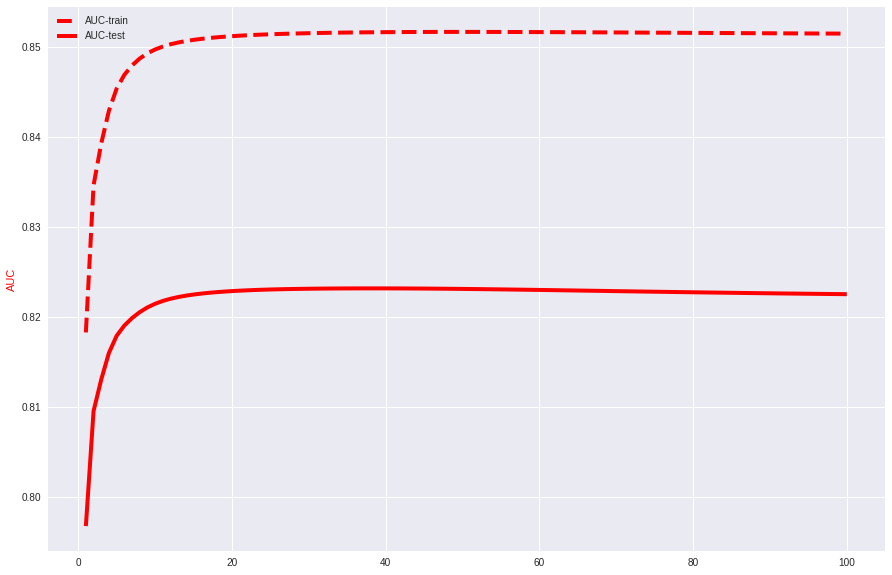

In [11]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=1, figsize=(15, 10))
x = np.arange(1, n_iter+1) * step_size
with plt.style.context('fivethirtyeight'):
    axes.plot(x, auc_train, label='AUC-train', color='r', ls="--")
    axes.plot(x, auc_test, label='AUC-test', color='r')
axes.set_ylabel('AUC', color='r')
axes.legend()

encoder = OneHotEncoder().fit(trade[predictors_holdings])
kf = KFold(n_splits=5,shuffle=True,random_state=37)
kf.get_n_splits(trade)
for train_index, test_index in kf.split(trade):
    X_train = trade.loc[train_index,predictors_holdings]
    X_test = trade.loc[test_index,predictors_holdings]
    y_train = trade.loc[train_index,target_holdings]
    y_test = trade.loc[test_index,target_holdings]
    y_train = y_train.astype(int).values.squeeze()
    y_test = y_test.astype(int).values.squeeze()
    y_train[y_train == 0] = -1
    X_train = encoder.transform(X_train)
    X_test = encoder.transform(X_test)
    print 'Starting training on new fold!'
    z = als.FMClassification(l2_reg_w=0.1, l2_reg_V=0.1, rank=4,n_iter=25)
    z.fit(X_train,y_train)
    y_pred_train = z.predict_proba(X_train)
    y_pred_test = z.predict_proba(X_test)
    y_train[y_train == -1] = 0
    print 'Train AUC: ',roc_auc_score(y_train,y_pred_train)
    print 'Test AUC: ',roc_auc_score(y_test,y_pred_test)

In [13]:
test = pd.read_csv('Challenge_20180423.csv',parse_dates=['DateKey'])
test = test.rename({'DateKey':'TradeDateKey'},axis=1)
test['BuySell'] = test['BuySell'].astype('category')
test['IsinIdx'] = test['IsinIdx'].astype(str) + '_' + test['BuySell'].astype(str)
test['IsinIdx'] = encoder_bondbs.transform(test['IsinIdx'])
test['TradeDateKey'] = '20180423'
test['TradeDateKey'] = pd.to_datetime(test.TradeDateKey)
test['year'] = test.TradeDateKey.dt.year
test['month'] = test.TradeDateKey.dt.month
test['weekofyear'] = test.TradeDateKey.dt.weekofyear
test_local = test.drop(['BuySell','TradeDateKey','month','CustomerInterest'],axis=1)
test_local['weekofyear'] = 16
#test_local = test_local.merge(customer,on=['CustomerIdx'],how='left')
#test_local = test_local.merge(bond,on=['IsinIdx'],how='left')
filtered = pd.read_csv('Trade.csv',parse_dates=['TradeDateKey'])
filtered['BuySell'] = filtered['BuySell'].astype('category')
filtered['IsinIdx'] = filtered['IsinIdx'].astype(str) + '_' + filtered['BuySell'].astype(str)
filtered['IsinIdx'] = encoder_bondbs.transform(filtered['IsinIdx'])
filtered['TradeStatus'] = filtered['TradeStatus'].astype('category')
filtered['CustomerInterest'] = filtered['CustomerInterest'].astype('bool')
filtered['year'] = filtered.TradeDateKey.dt.year
filtered['month'] = filtered.TradeDateKey.dt.month
filtered['weekofyear'] = filtered.TradeDateKey.dt.weekofyear
filtered.drop(['BuySell'],axis=1,inplace=True)
test_local = test_local.merge(filtered[['CustomerIdx','IsinIdx','year','weekofyear','CustomerInterest']],on=['CustomerIdx','IsinIdx','year','weekofyear'],how='left')
test_local['CustomerInterest'][test_local.CustomerInterest.isnull()] = False
del filtered
test_local.head()
y_true = test_local.CustomerInterest.astype(int).values
test_local = encoder.transform(test_local[predictors_holdings])
y_scores = z.predict_proba(test_local)
roc_auc_score(y_true, y_scores)

KeyboardInterrupt: 

In [14]:
test = pd.read_csv('Challenge_20180423.csv',parse_dates=['DateKey'])
test = test.rename({'DateKey':'TradeDateKey'},axis=1)
test['BuySell'] = test['BuySell'].astype('category')
test['TradeDateKey'] = '20180423'
test['TradeDateKey'] = pd.to_datetime(test.TradeDateKey)
test['year'] = test.TradeDateKey.dt.year
test['month'] = test.TradeDateKey.dt.month
test['weekofyear'] = test.TradeDateKey.dt.weekofyear
test['BuySell'] = encoder_bs.transform(test['BuySell'].astype(str))
test_pred = encoder.transform(test[predictors_holdings])
test['CustomerInterest'] = z.predict_proba(test_pred)
test[['PredictionIdx','CustomerInterest']].to_csv('sub_sam_fm_holdings1_3.csv',index=False)